In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from qutip import *

### Simulation Settings

In [2]:
# Highest Fock state
nMax = 100

# Size of Wigner function to plot (set to match the plots from the paper)
xvec = np.linspace(-3, 3, 200)
pvec = np.linspace(-2, 12, 200)

# QuTip integration settings
options = Options()
options.num_cpus = 5
options.nsteps = 100000

#### Generate Ideal Cubic Phase State

Text(0, 0.5, 'Momentum')

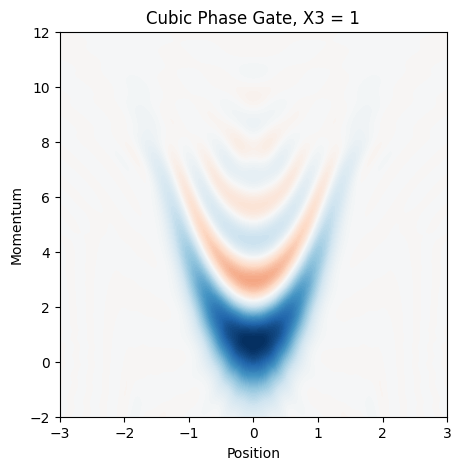

In [3]:
ideal_x = position(nMax) # Position Operator
ideal_H = - ideal_x**3 # Cubic Phase Operator

ideal_psi0 = basis(nMax) # Initialise in |n=0> state

ideal_output = mesolve(H = ideal_H, rho0 = ideal_psi0, tlist = [0.0, 1.0], options = options)
ideal_rho = ideal_output.states[-1]
ideal_W = wigner(ideal_rho, xvec, pvec)

# -------------------- Plot Results -------------------- #
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    
im = ax.contourf(xvec, pvec, ideal_W, 100, norm=mpl.colors.Normalize(-.25,.25), cmap=plt.get_cmap('RdBu'))
ax.set_title("Cubic Phase Gate, X3 = 1")
ax.set_xlabel("Position")
ax.set_ylabel("Momentum")

#### Define Operators

In [4]:
a = tensor(qeye(2), destroy(nMax))
x = tensor(qeye(2), position(nMax))

sX = tensor(sigmax(), qeye(nMax))
sY = tensor(sigmay(), qeye(nMax))
sZ = tensor(sigmaz(), qeye(nMax))
sM = tensor(destroy(2), qeye(nMax))

#### Find Correct Displacement Operation
To ensure the correct displacement is being done, find parameters such that $\ket{+}$ is moved in one direction.

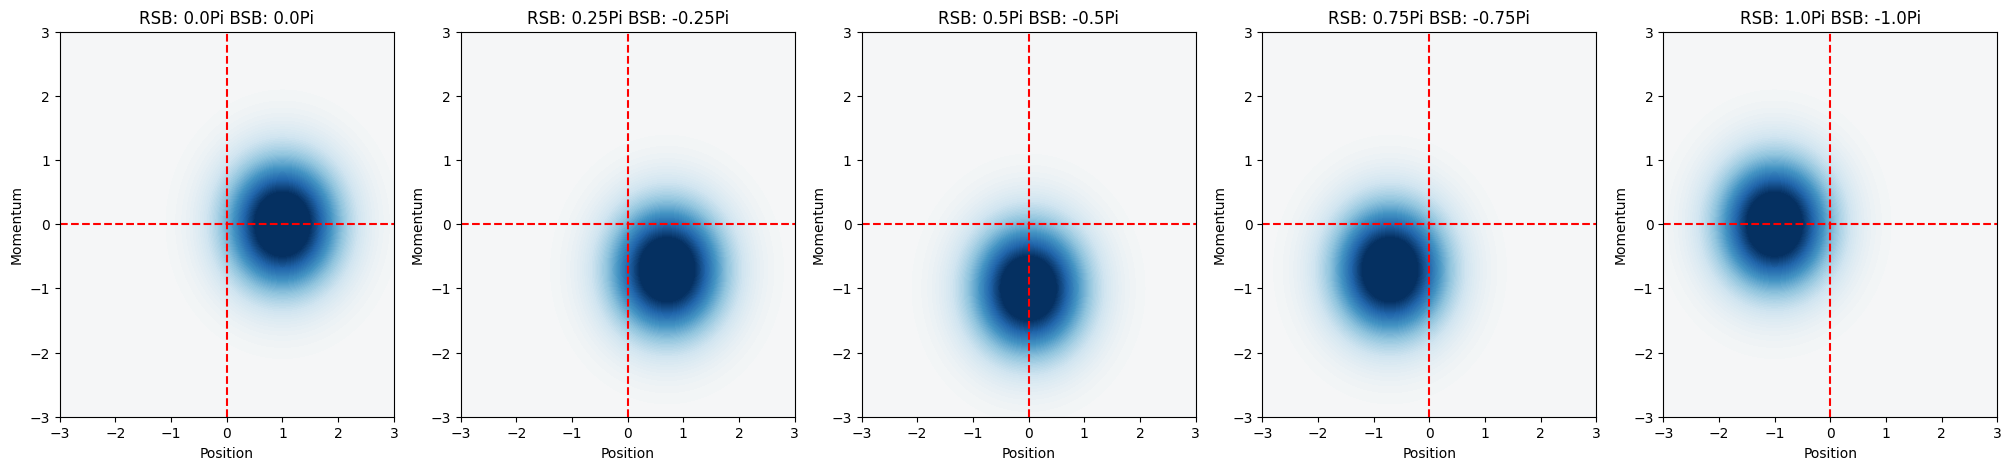

In [12]:
# -------------------- Setup Operators -------------------- #
rsb = 1/np.sqrt(2) * a * sM.dag()
def rsb_coeff(t, args):
    return np.exp(1j * args['rsb_phase']) * np.exp(-1j * args['detuning'] * t)

rsbp = 1/np.sqrt(2) * a.dag() * sM 
def rsbp_coeff(t, args):
    return np.exp(-1j * args['rsb_phase']) * np.exp(1j * args['detuning'] * t)

bsb = 1/np.sqrt(2) * a.dag() * sM.dag()
def bsb_coeff(t, args):
    return np.exp(1j * args['bsb_phase']) * np.exp(-1j * args['detuning'] * t)

bsbp = 1/np.sqrt(2) * a * sM
def bsbp_coeff(t, args):
    return np.exp(-1j * args['bsb_phase']) * np.exp(1j * args['detuning'] * t)

ion_displace = [
    [rsb, rsb_coeff], [rsbp, rsbp_coeff], [bsb, bsb_coeff], [bsbp, bsbp_coeff]
]

args = {"detuning": 0, "rsb_phase": 0, "bsb_phase": 0}

# -------------------- Verify Above Hamiltonian is Correct -------------------- #
# Change plot range on Wigner so that it's easier to see
xxvec = np.linspace(-3, 3, 200)
ppvec = np.linspace(-3, 3, 200)

# Trapped Ion Position Operator
initial_state = tensor(basis(2,0) + basis(2,1), basis(nMax, 0)) # |+> state -> If displacement has correct PauliX control, no splitting should be observed

offset_phase = (3/2) * np.pi
scan_phase = [offset_phase + i * np.pi/4 for i in range(5)]

res = []
for phase in scan_phase:
    args['rsb_phase'] = phase
    args['bsb_phase'] = -phase

    output = mesolve(H = ion_displace, rho0 = initial_state, tlist = [0.0, 1.0], args = args).states[-1]
    motion = ptrace(output, 1)
    w = wigner(motion, xxvec, ppvec)

    res.append(w)

# -------------------- Plot Results -------------------- #
fig, ax = plt.subplots(1, len(scan_phase), figsize = (int(5 * len(scan_phase)), 5))

for i in range(len(scan_phase)):
    ax[i].vlines(0, ymin = -3, ymax = 3, colors = 'r', linestyles = 'dashed')
    ax[i].hlines(0, xmin = -3, xmax = 3, colors = 'r', linestyles = 'dashed')

    im = ax[i].contourf(xxvec, ppvec, res[i], 100, norm=mpl.colors.Normalize(-.25,.25), cmap=plt.get_cmap('RdBu'))
    ax[i].set_title("RSB: " + str((scan_phase[i] - offset_phase)/np.pi) + "Pi BSB: " + str((-scan_phase[i] + offset_phase)/np.pi) + "Pi")
    ax[i].set_xlabel("Position")
    ax[i].set_ylabel("Momentum")

#### Characteristic Function Measurement Sequence

Initial qubit rotation:

$ R (\theta, \phi) = \cos(\theta/2) I - i \sin(\theta/2) [\cos(\phi) \sigma_x + \sin(\phi) \sigma_y ] \quad \rightarrow \quad R (\theta, \phi = 0) = \cos(\theta/2) I - i \sin(\theta/2) \sigma_x$  

Followed by the $\sigma_x$ controlled displacement, which is given by the ion_displace Hamiltonian defined above with RSB Phase + BSB Phase = 0

In [24]:
def rot(angle):
    p1 = np.cos(angle/2) * tensor(qeye(2), qeye(nMax))
    p2 = -1j * np.sin(angle/2) * tensor(sigmax(), qeye(nMax))

    return p1 + p2

offset_phase = (3/2) * np.pi # Such that when set RSB Phase = BSB Phase = 0 -> Push along +x position axis.
# With this definition, keep track of angle using BSB Phase because it makes more sense.

args = {"detuning": 0, "rsb_phase": 0, "bsb_phase": 0}

# -------------------- Setup Operators -------------------- #
rsb = 1/np.sqrt(2) * a * sM.dag()
def rsb_coeff(t, args):
    return np.exp(1j * args['rsb_phase']) * np.exp(-1j * args['detuning'] * t)

rsbp = 1/np.sqrt(2) * a.dag() * sM 
def rsbp_coeff(t, args):
    return np.exp(-1j * args['rsb_phase']) * np.exp(1j * args['detuning'] * t)

bsb = 1/np.sqrt(2) * a.dag() * sM.dag()
def bsb_coeff(t, args):
    return np.exp(1j * args['bsb_phase']) * np.exp(-1j * args['detuning'] * t)

bsbp = 1/np.sqrt(2) * a * sM
def bsbp_coeff(t, args):
    return np.exp(-1j * args['bsb_phase']) * np.exp(1j * args['detuning'] * t)

push = [
    [rsb, rsb_coeff], [rsbp, rsbp_coeff], [bsb, bsb_coeff], [bsbp, bsbp_coeff]
]

##### Try radial plot

Text(0.5, 0.98, 'Real Part')

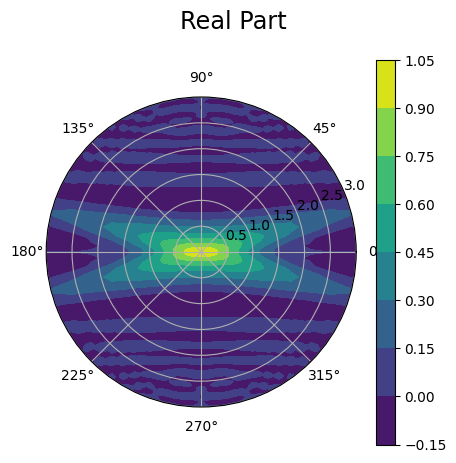

In [39]:
# For plotting
radius = np.linspace(0.001, 3.0, 101)
radius = [i for i in radius]

theta = np.linspace(offset_phase, offset_phase + 2 * np.pi, 101)
theta = [i for i in theta]

# For plotting & Storing Data
theta_array = [theta for i in range(len(radius))]
radius_array = [[radius[j] for i in range(len(theta))] for j in range(len(radius))]

nColumns = len(theta)
nRows = len(radius)

plot_data = np.zeros((nRows, nColumns))

# Plot settings
vmin = -1
vmax = 1
levels = 20
level_boundaries = np.linspace(vmin, vmax, levels + 1)

# Characteristic Function Simulation
initial_state = tensor(basis(2, 0), ideal_rho)

psi1 = rot(0) * initial_state

res = []

for phase in theta:
    for amp in radius:
        args['rsb_phase'] = phase
        args['bsb_phase'] = -phase

        output = mesolve(H = push, rho0 = psi1, tlist = [0, amp], args = args)
        state = output.states[-1]
        
        ion_state = ptrace(state, 0)
        proj = expect(sigmaz(), ion_state)

        res.append(proj)

counter = 0

for i in range(len(res)):
    if i > 1 and i % nRows == 0:
        counter += 1

    plot_data[i - counter * nRows][counter] = res[i]

fig, ax = plt.subplots(subplot_kw = dict(projection='polar'), figsize = (5, 5))
#ax.set_theta_zero_location("E")
#ax.set_theta_direction(1)

cax = ax.contourf(theta, radius, plot_data)
cbar = fig.colorbar(cax)
fig.suptitle("Real Part", size = 'xx-large')